In [5]:
import sys

sys.path.append("../")
sys.path.append("../src")

%load_ext autoreload
%autoreload 2


In [6]:
import networkx as nx
import pulser
from matplotlib import pyplot as plt
from networkx.algorithms import approximation
import ray
from ray import tune
from src.solver.opt_vqaa import VQAA
from src.solver.utils.graph_register import GraphRegister
import torch

In [7]:
ray.shutdown()
ray.init(num_cpus=8)

2024-02-05 17:19:27,294	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.11.0
Ray version:,2.9.0
Dashboard:,http://127.0.0.1:8265


In [17]:
def plot_distribution(counts, actual_solution):
    counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True)[:20])
    color_dict = {key: "r" if key in actual_solution else "g" for key in counts}
    plt.figure(figsize=(12, 6))
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.bar(counts.keys(), counts.values(), width=0.5, color=color_dict.values())
    plt.xticks(rotation="vertical")
    plt.show()


REGISTER_FILE = "data/registers/dataset/9_rectangle_3_3_6.json"

[0, 5]
[3, 4, 7, 6, 5, 0, 2, 1, 8]
Maximum independent set of G: ['100001000', '100000010', '100000001', '010000100', '010000001', '001100000', '001000100', '001000010', '000100001', '000001100']


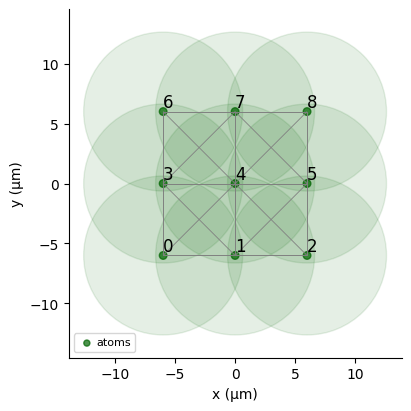

['100001000',
 '100000010',
 '100000001',
 '010000100',
 '010000001',
 '001100000',
 '001000100',
 '001000010',
 '000100001',
 '000001100']

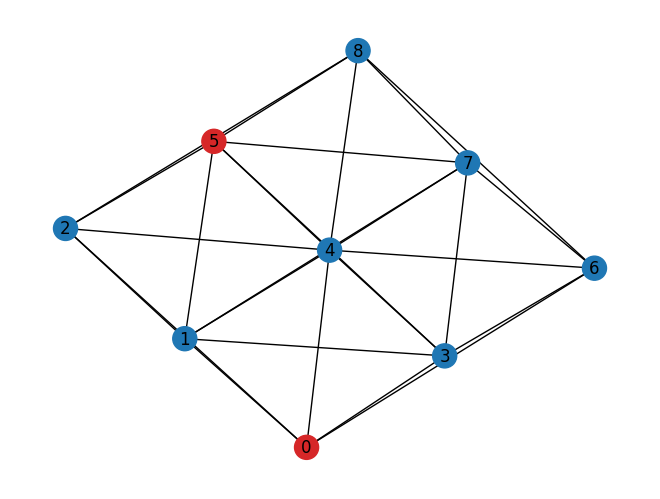

In [37]:
from src.solver.classical import get_mis


def explore_graph(file, radius=1):
    register = GraphRegister.from_json(file)

    graph = register.graph_radius(radius)

    I = get_mis(graph)
    num_nodes = graph.number_of_nodes()
    print(I[0])
    print([n for n in graph])
    MIS = []
    for instance in I:
        bitstring = "".join("1" if node in instance else "0" for node in range(num_nodes))
        MIS.append(bitstring)

    print(f"Maximum independent set of G: {MIS}")
    register.draw(
        blockade_radius=pulser.devices.Chadoq2.rydberg_blockade_radius(1.0),
        draw_graph=True,
        draw_half_radius=True,
    )
    pos = nx.spring_layout(graph)
    nx.draw(
        graph,
        pos=pos,
        with_labels=True,
        node_color=["tab:red" if n in I[0] else "tab:blue" for n in graph],
    )

    return MIS


explore_graph(REGISTER_FILE)

In [10]:
counts, result, params = VQAA(
    register_file=REGISTER_FILE, optimisation_rounds=100, store_results=False
)

plot_distribution(counts, bitstring)

print(result)

2024-02-05 17:19:55,183	WARNING tune.py:186 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2024-02-05 17:19:55,643	WARNING tune.py:1057 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: tune.run(..., resume=True)
2024-02-05 17:19:55,698	WARNING experiment_analysis.py:193 -- Failed to fetch metrics for 1 trial(s):
- QAA_scorer_462c16a9: FileNotFoundError('Could not fetch metrics for QAA_scorer_462c16a9: both result.json and progress.csv were not found at /Users/mathieug/ray_results/QAA_scorer_2024-02-05_17-19-28/QAA_scorer_462c16a9_79_fall_time=224,final_detuning=7.7758,init_detuning=7.3220,omega=10.4298,rise_time=195_2024-02-05_17-19-55')


Best trial config: {'rise_time': 1414, 'fall_time': 1022, 'omega': 9.716604037883805, 'init_detuning': 1.1000350867583353, 'final_detuning': 2.9410824181955224}
Best trial final score: 1.0832526514285714


NameError: name 'bitstring' is not defined

In [ ]:
ray.shutdown()

In [ ]:
from src.solver.utils.graph_register import generate_multiple_configurations

# generate_multiple_configurations("./data/registers/dataset", max_qubits=12)

In [ ]:
import os
import src.solver.ml.dataset as pre
from src.solver.opt_vqaa import VQAA

BASE_PATH = "./data/registers/results/results_500_samples/"

for file_path in sorted(os.listdir(BASE_PATH), reverse=True):
    # print(file_path)
    path = os.path.join(BASE_PATH, file_path)
    VQAA(register_file=path, optimisation_rounds=500, store_results=True)

    # try:
    #     spl = path.split("_")
    #     distance = int(spl[4][0])
    #     # data, labels = pre.data_from_file(path)
    #     # print(file_path)
    # except:
    #     VQAA(register_file=path, optimisation_rounds=100, store_results=True)

Best trial config: {'rise_time': 347, 'fall_time': 3320, 'omega': 7.956939841392223, 'init_detuning': 5.586091594384531, 'final_detuning': 3.389300443807837}
Best trial final score: 4.2503181526050415


In [ ]:
import src.solver.ml.pre_processing as pre

data, labels = pre.data_from_file(BASE_PATH + "/8_rectangle_4_2_10.json")
print(data)
print(labels)

ModuleNotFoundError: No module named 'src.solver.ml.pre_processing'

Best trial config: {'rise_time': 1095, 'fall_time': 2853, 'omega': 7.070235427043221, 'init_detuning': 2.6444457610593695, 'final_detuning': 2.2906289274130884}
Best trial final score: 0.6117470561151079


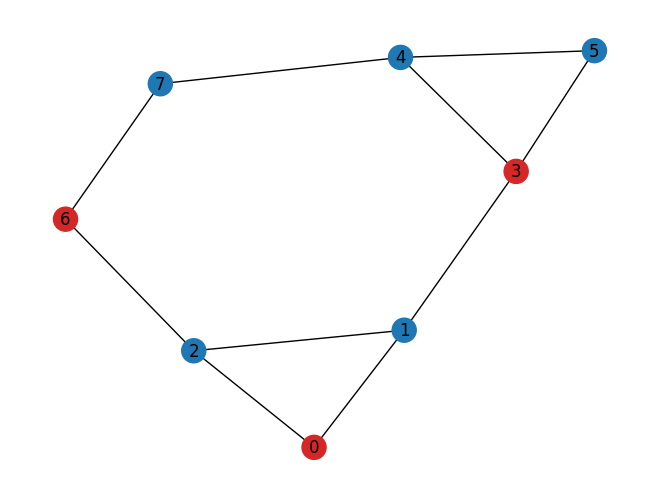

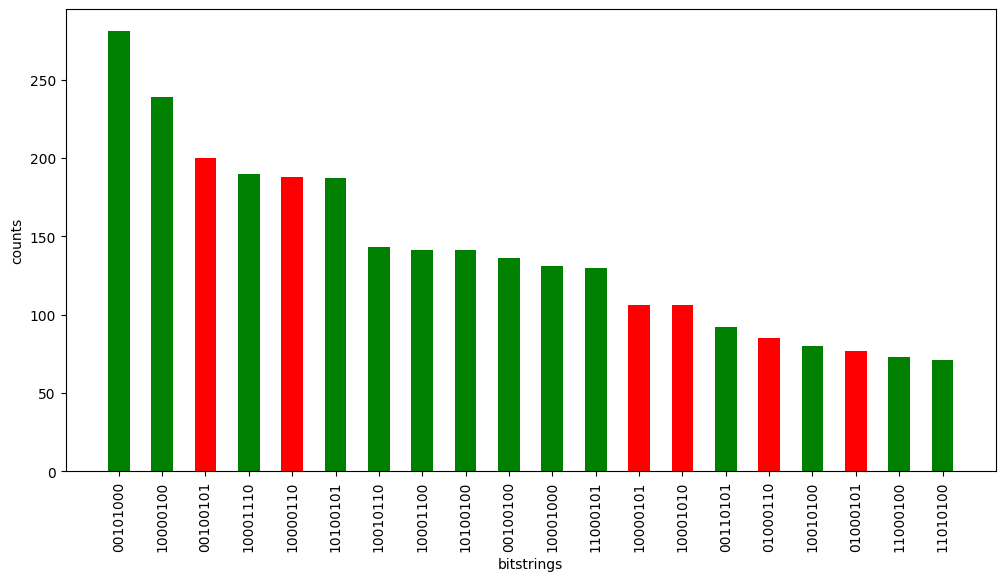

In [38]:
import os
import ray
import ray.tune

BASE_PATH = "data/registers/demo"


file = os.path.join(BASE_PATH, "ethyl.json")

bitstring = explore_graph(file)
print(bitstring)

counts, result, params = VQAA(register_file=file, optimisation_rounds=10, store_results=False)

plot_distribution(counts, bitstring)

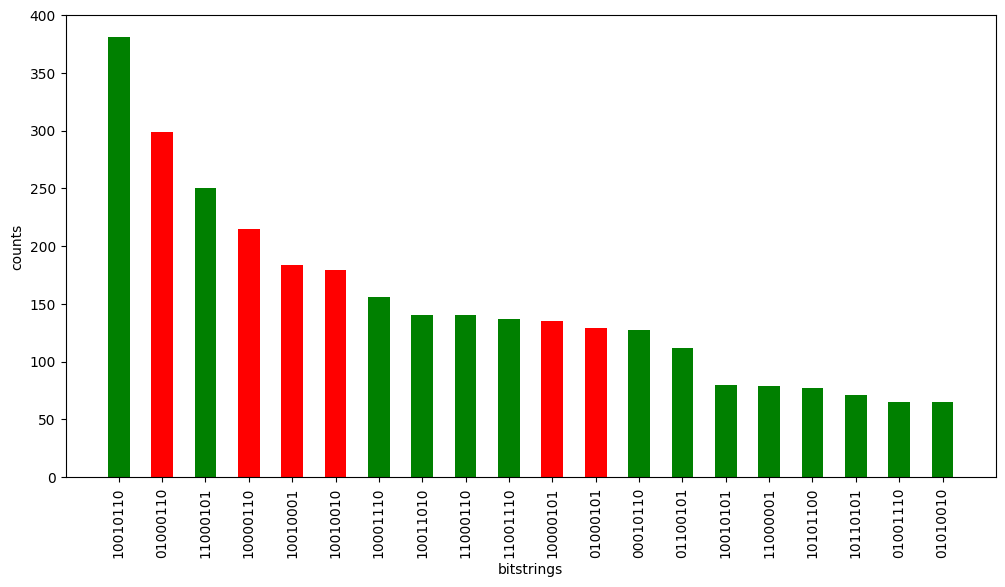

In [33]:
from src.solver.ml.mlqaa import MLQAA


counts, result, params = MLQAA(register_file=file, store_results=False)

plot_distribution(counts, bitstring)